In [12]:
library(Seurat)
library(tidyverse)
source("/shareb//zliu//analysis/hires_gastrulation/CHARMtools/Rlibs/plotFun.R")
library(ComplexHeatmap)
library(circlize)
library(ggpubr)

In [4]:
hires <- readRDS("../plotadj/hires_validation.rds")

In [5]:
hires[[]] %>% write_tsv("hires_metadata.tsv")

## Figure1 B C

Rows: 4272 Columns: 20
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): cell, tissue, treatment, age, sex, father, mother, restriction enzy...
dbl (8): read length (bp), raw throughput (Gb), raw intra (%), dup rate (%),...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


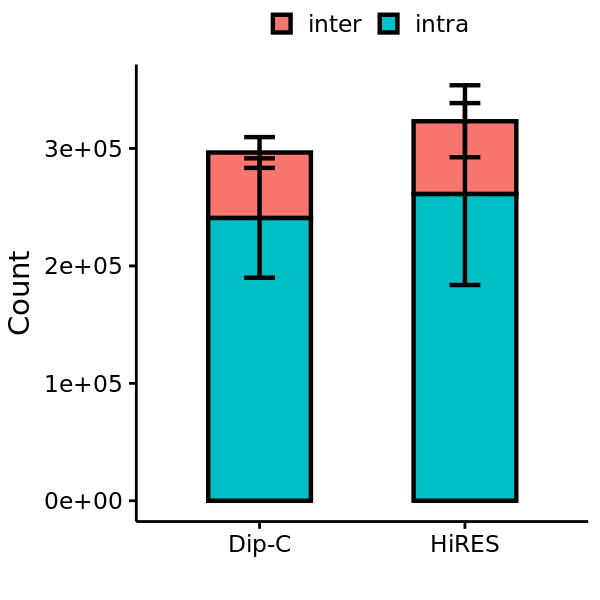

In [26]:
hires_meta <- hires[[]]
dipc_meta <- read_tsv("../Tan2021/HiC/all_dipc.metadata.tsv")

#,"P309","P347"
dipc_stat <- dipc_meta %>% filter(tissue =="cortex",age %in% c("P56"),`cell-type cluster`!="Empty Well") %>% select(contacts,`intra (%)`) %>%
    mutate(intra = round(contacts * `intra (%)`/100),method = "Dip-C")  
names(dipc_stat) <- c("contacts","intra_ratio","intra","method")

hires_stat <- hires_meta %>% select(pairs_clean3,inter_pairs_clean3) %>% 
        mutate(contacts = pairs_clean3,intra = pairs_clean3 - inter_pairs_clean3,
        intra_ratio = contacts / intra , method = "HiRES") %>% select(3:6)

dedup_pairs <- rbind(dipc_stat,hires_stat)
dedup_pairs <- dedup_pairs %>% mutate(inter = contacts - intra) %>% 
 select(-intra_ratio,contacts,-contacts) %>% gather(Type,Count,-method) #%>% 
options(repr.plot.width=3, repr.plot.height=3.5,repr.plot.res=200)
p <- ggbarplot(dedup_pairs,x="method",y="Count",fill="Type",group="Type",label=F, #size = 0,
               add = c("mean_sd") ,lab.nb.digits=1,width = 0.5) + xlab("") + 
    theme_Publication() + theme(legend.title=element_blank()) 
options(repr.plot.width = 2,repr.plot.height=2,repr.plot.res=300)
p

Rows: 261 Columns: 8
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): cellname, orig.ident
dbl (6): nCount_RNA, nFeature_RNA, nCount_SCT, nFeature_SCT, SCT_snn_res.0.8...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


method,meanCountUMI,sdCountUMI,meanCountGene,sdCounGene
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
HiRES,28867.47,14004.26,6759.188,1843.767
MALBAC_DT,11531.01,7373.10,3210.559,1259.076


Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


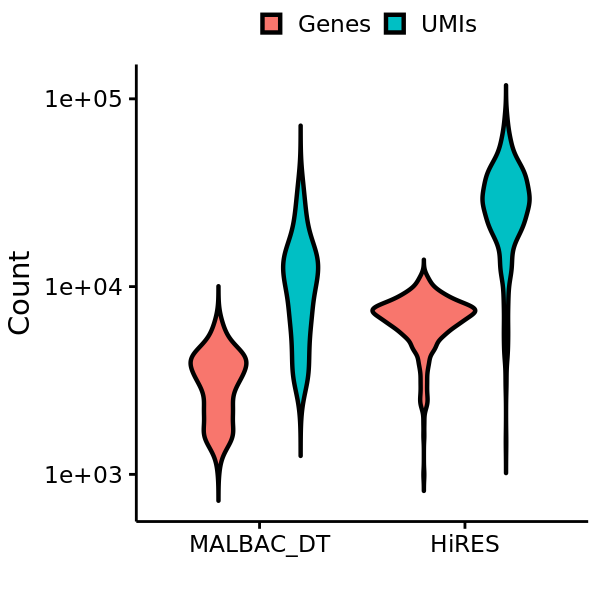

In [27]:
malbacdt_meta <- read_tsv("../Tan2021/RNA/RNAmeta.p56.tsv")

RNAcompare <- rbind(malbacdt_meta %>% select(nCount_RNA,nFeature_RNA)%>% mutate(method="MALBAC_DT"),
      hires[[]] %>% select(nCount_RNA,nFeature_RNA)%>% mutate(method="HiRES")) %>% as_tibble()
names(RNAcompare) <- c("UMIs","Genes","method")
RNAcompare %>% group_by(method) %>% summarise(meanCountUMI = mean(`UMIs`),sdCountUMI = sd(`UMIs`),
                                             meanCountGene = mean(`Genes`),sdCounGene = sd(`Genes`))

q <- RNAcompare %>%  gather(Type,Count,-method)%>%
ggviolin(x="method",y="Count",fill="Type",outlier.shape = NA)+ 
    scale_y_log10() + theme_Publication() + xlab("") + theme(legend.title=element_blank())
q

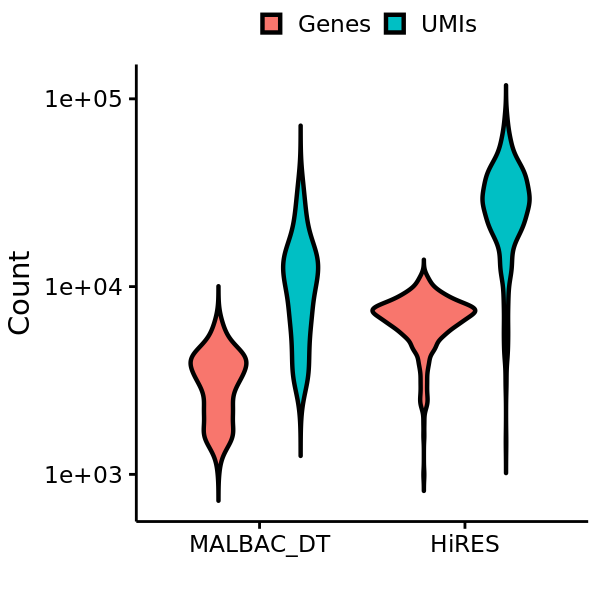

In [28]:
options(repr.plot.width=2, repr.plot.height=2,repr.plot.res=300)
q

In [29]:
options(repr.plot.width=3, repr.plot.height=2,repr.plot.res=300)
library(patchwork)
efficiency <- (q|p) + plot_layout(ncol = 2, widths = c(1, 1))

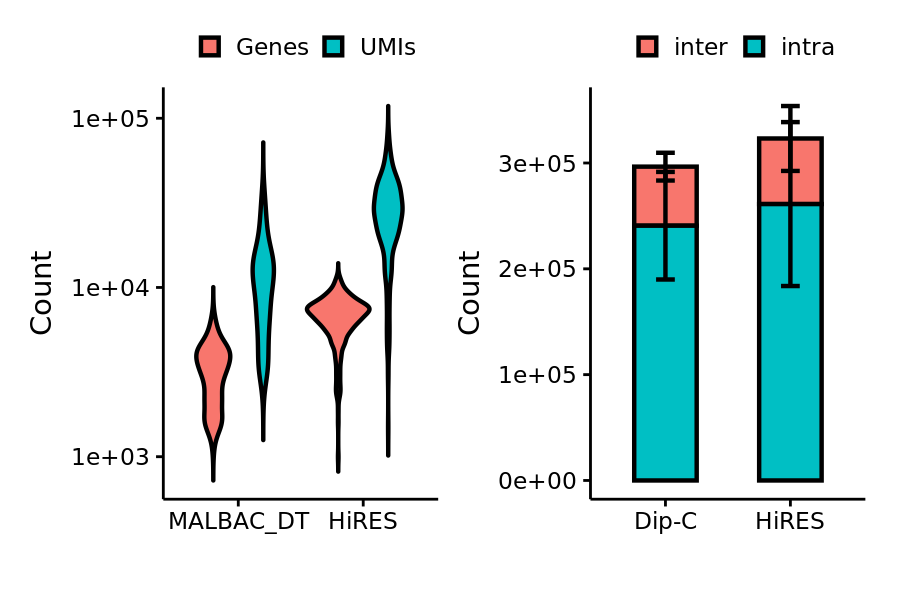

In [30]:
efficiency
efficiency %>% ggsave(filename = "efficiency.pdf",height = 1.5,width = 3,dpi = 300, units = "in")

## Figure1 D and E

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


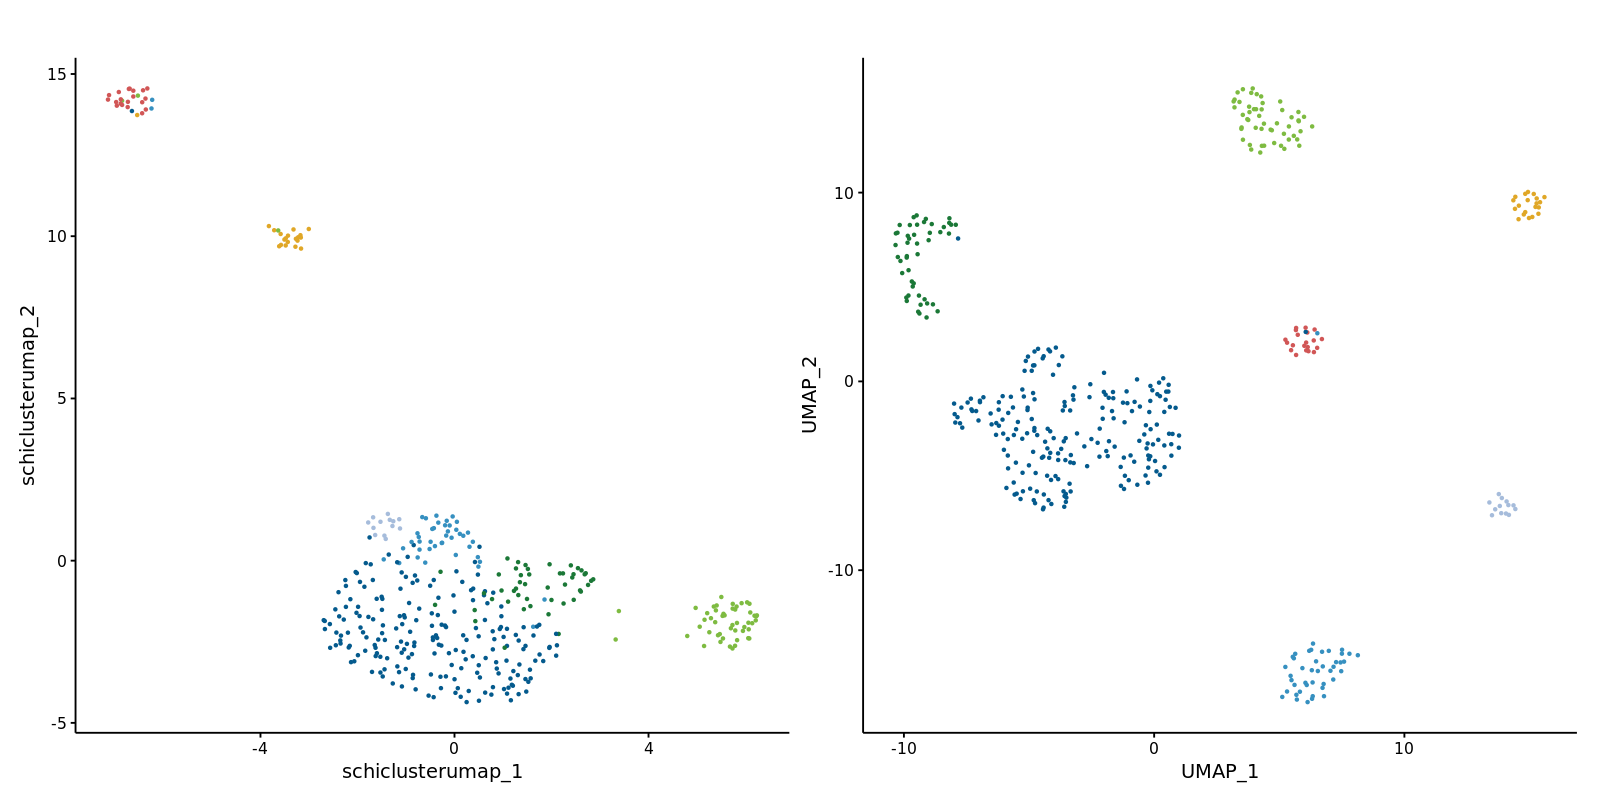

In [13]:
options(repr.plot.width=8, repr.plot.height=4,repr.plot.res=200)
cols = c("Ast"="#e0a727","Oli"="#d15656","Ex1"="#045a8d","Ex2"="#3690c0","Ex3"="#a6bcdb","In1"="#7ebb41","In2"="#1b7837")

a <- DimPlot(hires,label=F,reduction = "schiclusterumap",group.by = "celltype",cols=cols,pt.size=0.1) + theme_Publication() + ggtitle("") + NoLegend()
b <- DimPlot(hires,label=F,reduction = "umap",group.by = "celltype",cols=cols,pt.size=0.1) + theme_Publication()+ ggtitle("") + NoLegend()

(a|b)
(a | b)  %>% ggsave(filename = "umap_validation.pdf",height = 1.5,width = 3,dpi = 300, units = "in")

In [14]:
a <- a + theme(axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
         axis.ticks.y = element_blank(),
          axis.text.y = element_blank()) + xlab("scHiCluster UMAP 1") + ylab("scHiCluster UMAP 2")

b <- b + theme(axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
         axis.ticks.y = element_blank(),
          axis.text.y = element_blank()) + xlab("RNA UMAP 1") + ylab("RNA UMAP 2")

In [17]:
a %>% ggsave(filename = "hicumap.pdf",height = 2,width = 2,dpi = 300, units = "in")
b %>% ggsave(filename = "rnaumap.pdf",height = 2,width = 2,dpi = 300, units = "in")

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


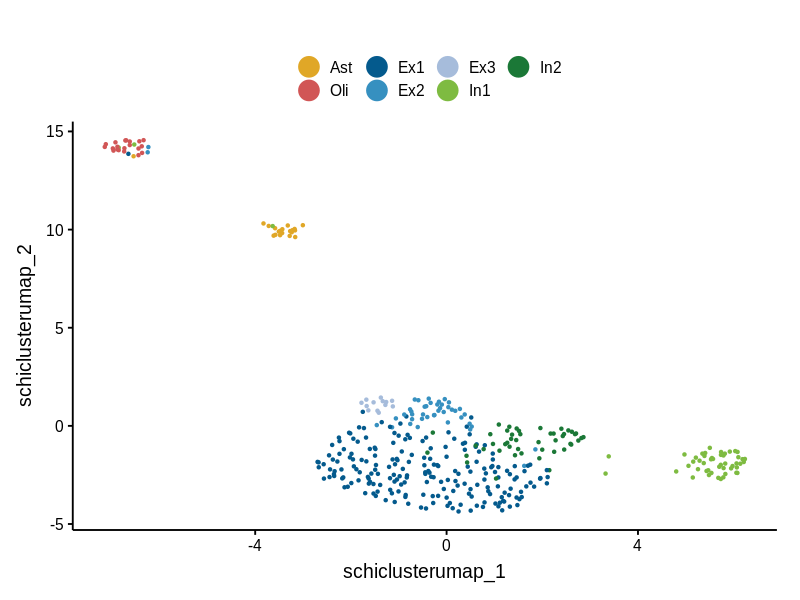

In [50]:
DimPlot(hires,label=F,reduction = "schiclusterumap",group.by = "celltype",cols=cols,pt.size=0.1) + theme_Publication() + ggtitle("") 

## Figure F

In [40]:
hires <- FindNeighbors(hires,reduction = "schicluster",dims = 1:38,graph.name = "sch.nn")
hires <- FindClusters(hires,graph.name = "sch.nn",resolution = 2)

Computing nearest neighbor graph

Computing SNN

Only one graph name supplied, storing nearest-neighbor graph only



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 399
Number of edges: 4186

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.3899
Number of communities: 13
Elapsed time: 0 seconds


1 singletons identified. 12 final clusters.



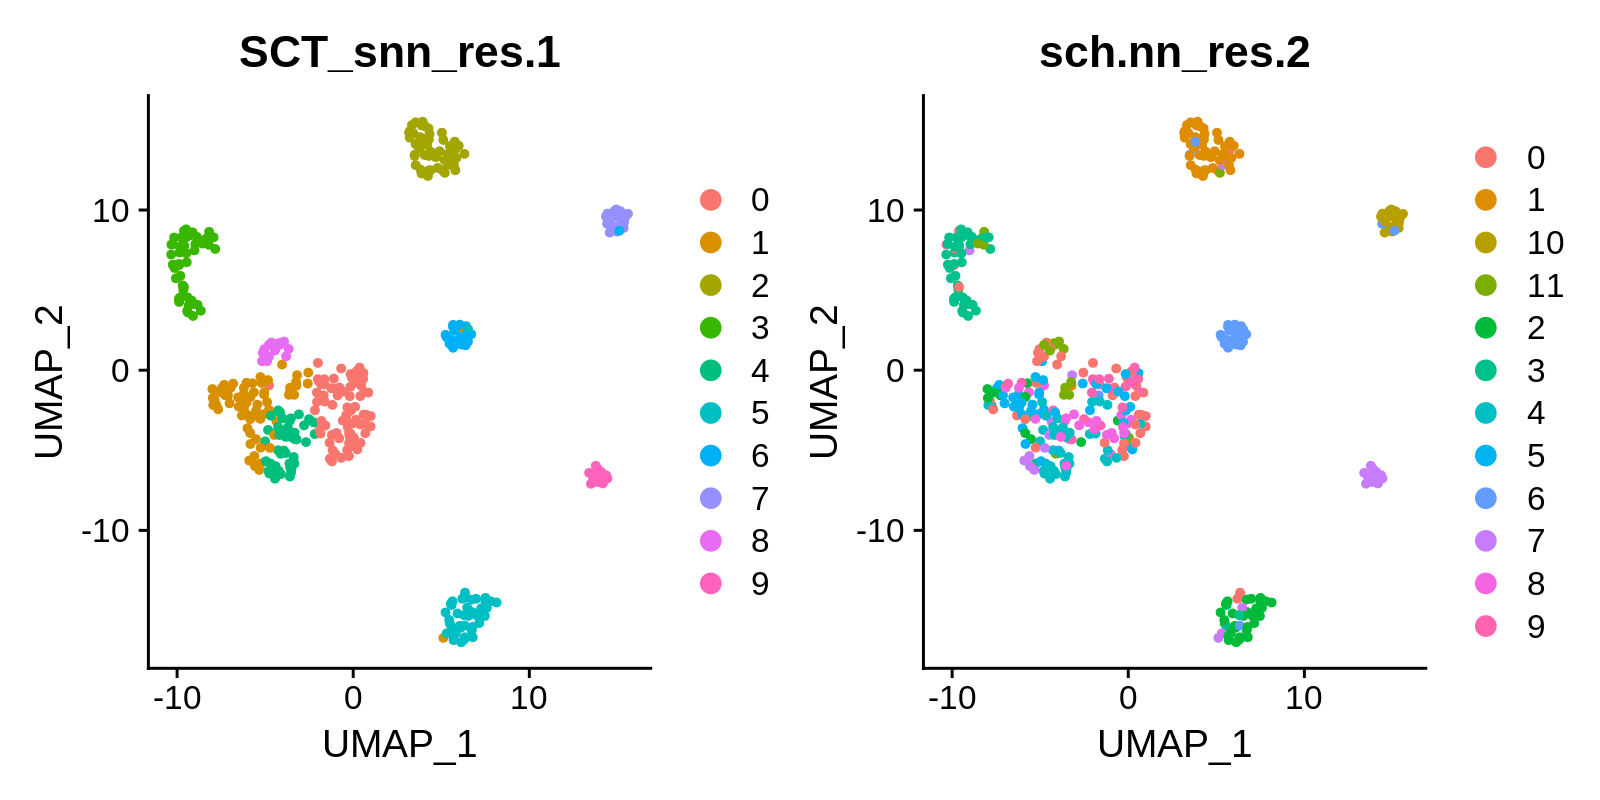

In [41]:
options(repr.plot.width=8, repr.plot.height=4,repr.plot.res=200)
DimPlot(hires,group.by = "SCT_snn_res.1")  | DimPlot(hires,group.by = "sch.nn_res.2") 

In [42]:
temp <- hires[[]] %>% select(cellname,celltype,SCT_snn_res.1,sch.nn_res.2) %>% rename(RNAtype = SCT_snn_res.1,HiCtype = sch.nn_res.2) %>% 
    group_by(RNAtype) %>% mutate(cellnum_RNAtype = n()) %>% group_by(RNAtype,HiCtype) %>%
    mutate(HiCnum_in_RNA  = n(),percent_hicinrna = HiCnum_in_RNA / cellnum_RNAtype)
mat <- temp %>% select(RNAtype,HiCtype,percent_hicinrna) %>% unique()%>% spread(HiCtype,percent_hicinrna)%>% column_to_rownames("RNAtype")
mat[is.na(mat)] <- 0

In [43]:
temp%>% ungroup()%>% select(celltype,RNAtype) %>% group_by(celltype,RNAtype)%>% summarise(count = n()) %>%
    filter(count > 1) %>% arrange(celltype) %>% select(-count) %>% column_to_rownames("RNAtype") -> rowAnno_df
leftAnno <- rowAnnotation(celltype = anno_simple(rowAnno_df,col = cols),show_annotation_name=F,
                 gap = unit(c(10), "mm"))
col_fun = colorRamp2(seq(from = 0,to=1,length.out = 8), c("#ffffcc","#ffeda0","#fed976","#feb24c","#fd8d3c","#fc4e2a","#e31a1c","#b10026"))


options(repr.plot.width=4, repr.plot.height=3,repr.plot.res=200)
p <- as.matrix(mat)[rownames(rowAnno_df),c("6",3,1,7,2,0,11,4,8,5,9,10)] %>% 
    Heatmap(col = col_fun,cluster_rows = F,cluster_columns = F,left_annotation = leftAnno,
            heatmap_legend_param = list(title = "RNA cell %"))

`summarise()` has grouped output by 'celltype'. You can override using the `.groups` argument.


In [44]:
col_fun = colorRamp2(seq(from = 0,to=1,length.out = 8), c("#ffffcc","#ffeda0","#fed976","#feb24c","#fd8d3c","#fc4e2a","#e31a1c","#b10026"))


options(repr.plot.width=4, repr.plot.height=3,repr.plot.res=200)
p <- as.matrix(mat)[rownames(rowAnno_df),c("6",3,1,7,2,0,11,4,8,5,9,10)] %>% 
    Heatmap(col = col_fun,cluster_rows = F,cluster_columns = F,right_annotation = leftAnno,
            row_names_side = "left",
            heatmap_legend_param = list(title = "RNA cell %"))
p

In [49]:
pdf("clustering_compare.pdf", width = 4, height = 3,bg = "white",colormodel = "cmyk",fonts = "Helvetica") 
# Code of the plot
draw(p)
# Close the graphics device
dev.off() 

png 
  2